**Import**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

**EDA**

In [3]:
df = pd.concat([train, test])

In [4]:
df = df.set_index(["PassengerId"])

In [5]:
cleanup_nums = {"Sex":       {"male": 1, "female": 2},
                "Embarked":  {"S": 1, "C": 2, "Q": 3}}

df = df.replace(cleanup_nums)

<Axes: >

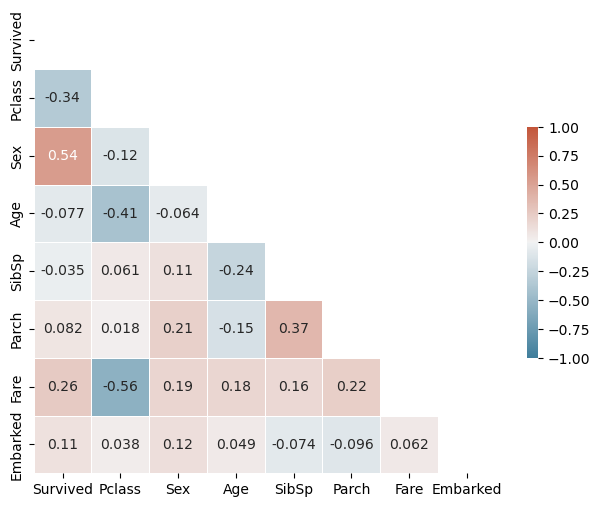

In [6]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [7]:
df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].median(), inplace=True)

**Age**

In [8]:
import re
df['Title'] = df.Name.apply(lambda x: re.search(r',\s(.+?)\.', x).group(1))
df.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

<Axes: >

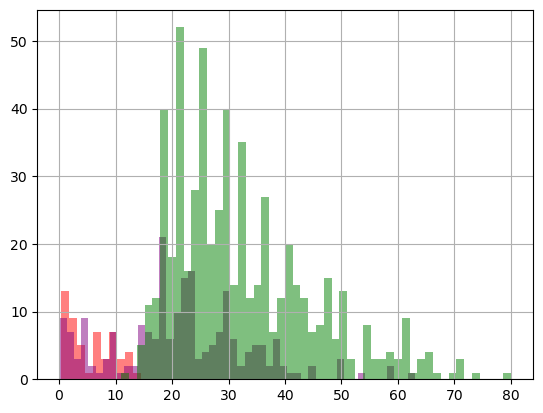

In [9]:
df.loc[df.Title=='Master','Age'].hist(alpha=0.5, bins=10, color='red', label='Master')
df.loc[df.Title=='Miss','Age'].hist(alpha=0.5, bins=50, color='purple', label='Miss')
df.loc[df.Title=='Mr','Age'].hist(alpha=0.5, bins=50, color='green', label='Mr')

In [10]:
import random as r
df_master = df[df['Title']=='Master']
df_master['Age'].fillna(r.randint(0, 16), inplace=True)
df_miss = df[df['Title']=='Miss']
df_miss['Age'].fillna(df_miss['Age'].mean(), inplace=True)
df_mr = df[df['Title']=='Mr']
df_mr['Age'].fillna(df_mr['Age'].median(), inplace=True)
df_mrs = df[df['Title']=='Mrs']
df_mrs['Age'].fillna(df_mr['Age'].mean(), inplace=True)
df_others = pd.concat([df[df['Title']=='Rev'], df[df['Title']=='Dr'], df[df['Title']=='Col'], df[df['Title']=='Mlle'],
        df[df['Title']=='Dona'], df[df['Title']=='Ms'], df[df['Title']=='Lady'], df[df['Title']=='Sir'], 
        df[df['Title']=='Mme'], df[df['Title']=='Don'], df[df['Title']=='Capt'], df[df['Title']=='the Countess'],
        df[df['Title']=='Jonkheer'], df[df['Title']=='Major']])
df_others['Age'].fillna(df_others['Age'].mean(), inplace=True)

In [11]:
df = pd.concat([df_master, df_miss, df_mr, df_mrs, df_others])

**Cabin**

In [12]:
df['Cabin'] = df['Cabin'].dropna().map(lambda cabin: cabin[0])

In [13]:
df = df.sort_values('PassengerId')

In [14]:
df = df.drop(['Name', 'Title', 'Ticket'], axis=1)

In [15]:
df['Cabin'].fillna('T', inplace=True)

In [16]:
df.replace({'Cabin' : {'A' : 0.467, 'B' : 0.745, 'C' : 0.593, 'D' : 0.758, 
                       'E' : 0.75, 'F' : 0.615, 'G' : 0.5, 'T' : 0.3}}, inplace=True)

In [17]:
df_train = df.iloc[:891,:]
df_test = df.iloc[891:,:]
X_train = df_train.drop(['Survived'], axis=1)
y_train = df_train.Survived
X_test = df_test.drop(['Survived'], axis=1)

**Model**

In [18]:
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Sex', 'Embarked']
target = 'Survived'

In [19]:
X = df_train[features]
y = df_train[target]

In [20]:
xgboost_params = {
    'colsample_bytree': 0.9716304348597584, 
    'gamma': 0.03174969063787792,
    'learning_rate': 0.0064203890498838925,
    'max_depth': 3, 
    'min_child_weight': 1,
    'n_estimators': 896, 
    'subsample': 0.735285745040819,
    'random_state': 42
}

xgboost_params1 = {
    'colsample_bytree': 0.5, 
    'gamma': 1,
    'learning_rate': 0.021347781051389365,
    'max_depth': 9, 
    'min_child_weight': 3,
    'n_estimators': 1461, 
    'subsample': 0.5,
    'random_state': 42
}

lgb_params = {
    'colsample_bytree': 0.5, 
    'learning_rate': 0.02687427427417419,
    'max_depth': 4,
    'min_child_samples': 5,
    'n_estimators': 500,
    'num_leaves': 10,
    'reg_alpha': 1.0,
    'reg_lambda': 0.0,
    'subsample': 0.6595129808730302,
    'seed': 42
}

lgb_params1 = {
    'colsample_bytree': 0.8997767208035865, 
    'learning_rate': 0.022463430135605245,
    'max_depth': 7,
    'min_child_samples': 73,
    'n_estimators': 2808,
    'num_leaves': 75,
    'reg_alpha': 0.42417807246068207,
    'reg_lambda': 0.6502841017477626,
    'subsample': 0.6765419227639857,
    'seed': 42
}

In [21]:
models = {
    'xgboost': XGBClassifier(**xgboost_params),
    'xgboost1': XGBClassifier(**xgboost_params1),
    'lgb': lgb.LGBMClassifier(**lgb_params),
    'lgb1': lgb.LGBMClassifier(**lgb_params1),
}

In [22]:
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
m = []
scores = []

In [23]:
import time
start = time.time()

for train_idx, val_idx in skf.split(X, y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    
    for model in models.values():
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        val_preds = pipeline.predict_proba(X_valid)
        val_score = accuracy_score(y_valid, pipeline.predict(X_valid))
        m.append(pipeline)
        scores.append(val_score)
        
print(f'{scores}')
print('-' * 45)
print(f'{np.mean(scores)}')
print('-' * 45)  

end = time.time()
print(f'it takes {end - start} seconds')

[0.9333333333333333, 0.9, 0.8666666666666667, 0.9166666666666666, 0.85, 0.85, 0.8666666666666667, 0.85, 0.8, 0.85, 0.8166666666666667, 0.8166666666666667, 0.8833333333333333, 0.9, 0.8833333333333333, 0.9, 0.9166666666666666, 0.8166666666666667, 0.8333333333333334, 0.8166666666666667, 0.85, 0.8333333333333334, 0.8333333333333334, 0.8166666666666667, 0.7796610169491526, 0.8135593220338984, 0.7966101694915254, 0.8135593220338984, 0.7627118644067796, 0.8305084745762712, 0.7966101694915254, 0.847457627118644, 0.847457627118644, 0.8135593220338984, 0.8305084745762712, 0.7966101694915254, 0.8135593220338984, 0.8135593220338984, 0.8135593220338984, 0.8305084745762712, 0.7966101694915254, 0.8305084745762712, 0.8135593220338984, 0.8135593220338984, 0.864406779661017, 0.8135593220338984, 0.864406779661017, 0.8305084745762712, 0.8135593220338984, 0.8305084745762712, 0.7966101694915254, 0.8305084745762712, 0.847457627118644, 0.8983050847457628, 0.864406779661017, 0.8983050847457628, 0.8474576271186

**Export**

In [24]:
preds = [0]
for model in m:
    preds += model.predict_proba(df_test[features])

preds = preds/len(m)
result = [round(sublist[1]) for sublist in preds]

In [25]:
submission['Survived'] = result

In [26]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
